# Лабораторная работа №2
# Изучение алгоритмов сжатия LZ77 и Хаффмана

## Описание
### 1. Алгоритм LZ77 (Lempel-Ziv 1977) 
Этот алгоритм основан на "скользящем окне". Он читает файл и ищет повторяющиеся последовательности символов, которые уже встречались ранее. Алгоритм заменяет последовательность короткой ссылкой вида (смещение назад, длина совпадения, следующий символ).
Таким образом, он хорошо устаняет контекстную избыточность, сжимая повторяющиеся слова в тексте, одинаковые участки в изображениях, тишину в аудио и т.д. 

### 2. Алгоритм Хаффмана 
Алгоритм статический: сначала анализирует весь файл, чтобы подсчитать, как часто встречается каждый отдельный символ (байт). Затем он строит бинарное дерево, где самым частым символам присваиваются самые короткие битовые коды, а редким — самые длинные. Устраняет статическую избыточность. Он основан на том, что в данных одни символы встречаются гораздо чаще других (в русском тексте 'о' и 'а' встречаются чаще, чем 'ф' и 'щ').

## Ход работы
Модифицируем анализ энтропии из прошлой работы (здесь сжатые данные мы сохранять не будем, они будут передаваться потоком).

In [1]:
import os
import heapq
import struct
import math
import sys
import matplotlib.pyplot as plt
from collections import Counter

def analyze_data_stream(data_bytes: bytes, display_name: str):
    print(f"\n--- Энтропийный анализ для '{display_name}' ---")

    file_size = len(data_bytes)
    byte_counts = Counter(data_bytes)
    entropy = sum(-(count / file_size) * math.log2(count / file_size) for count in byte_counts.values())

    print(f"Размер: {file_size / 1024:.2f} КБ ({file_size} байт)")
    print(f"Энтропия (на байт): {entropy:.4f} бит/байт")
    
    output_filename = f"{display_name.replace(' ', '_').replace('(', '').replace(')', '')}_histogram.png"
    byte_values = range(256)
    all_counts = [byte_counts.get(i, 0) for i in byte_values]

    plt.figure(figsize=(12, 6))
    plt.bar(byte_values, all_counts, width=1.0, color='darkslateblue')
    plt.title(f'Гистограмма распределения байтов для\n"{display_name}"')
    plt.xlabel('Значение байта (0-255)'); plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xlim(-1, 256)
    plt.show()

Реализуем алгоритм `Хаффмана`:

In [2]:
# --- Huffman algorithm ---
class HuffmanNode:
    def __init__(self, symbol, freq, left=None, right=None):
        self.symbol, self.freq, self.left, self.right = symbol, freq, left, right
    def __lt__(self, other):
        return self.freq < other.freq

def _build_tree(frequency):
    priority_queue = [HuffmanNode(s, f) for s, f in frequency.items()]
    heapq.heapify(priority_queue)
    while len(priority_queue) > 1:
        left, right = heapq.heappop(priority_queue), heapq.heappop(priority_queue)
        merged = HuffmanNode(None, left.freq + right.freq, left, right)
        heapq.heappush(priority_queue, merged)
    return priority_queue[0] if priority_queue else None

def _generate_codes(node, prefix="", codebook={}):
    if node is None: return
    if node.symbol is not None: codebook[node.symbol] = prefix
    _generate_codes(node.left, prefix + "0", codebook)
    _generate_codes(node.right, prefix + "1", codebook)

def huffman_compress_binary(data: bytes):
    if not data: return b''
    frequency = Counter(data)
    root = _build_tree(frequency)
    codebook = {}
    _generate_codes(root, "", codebook)
    header = bytearray()
    header.append(len(frequency) % 256 if len(frequency) < 256 else 0)
    for symbol, freq in frequency.items():
        header.extend(struct.pack('>BI', symbol, freq))
    encoded_data_str = "".join([codebook[symbol] for symbol in data])
    padding = (8 - len(encoded_data_str) % 8) % 8
    header.append(padding)
    encoded_data_str += padding * "0"
    byte_array = bytearray(int(encoded_data_str[i:i+8], 2) for i in range(0, len(encoded_data_str), 8))
    return bytes(header) + bytes(byte_array)

Реализуем алгоритм `LZ77`:

In [3]:
# --- LZ77 algorithm ---
def lz77_compress_binary(data: bytes, window_size=4095, lookahead_size=16):
    compressed_data = bytearray()
    i = 0
    while i < len(data):
        match_offset, match_length = 0, 0
        search_buffer_start = max(0, i - window_size)
        search_buffer = data[search_buffer_start:i]
        
        for length in range(1, min(lookahead_size, len(data) - i) + 1):
            subsequence = data[i:i+length]
            pos = search_buffer.rfind(subsequence)
            if pos != -1:
                match_offset = len(search_buffer) - pos
                match_length = length
            else:
                break
        
        if match_length > 0:
            packed_offset_length = (match_offset << 4) | (match_length - 1)
            next_char_pos = i + match_length
            next_char = data[next_char_pos] if next_char_pos < len(data) else 0
            token = struct.pack('>HB', packed_offset_length, next_char)
            compressed_data.extend(token)
            i += match_length + 1
        else:
            token = struct.pack('>HB', 0, data[i])
            compressed_data.extend(token)
            i += 1
            
    return bytes(compressed_data)

Теперь возьмем два файла с предыдущей работы (`Gogol.txt`, `RT.bmp`) и применим к ним последовательно эти алгоритмы, но в различном порядке:

|| АНАЛИЗ ФАЙЛА: 'Gogol.txt'
Исходный размер: 756.59 КБ (774745 байт)

>>> Сценарий 1: LZ77 ->  Хаффман
    Итоговый размер: 442.81 КБ (453439 байт)
    Общий коэффициент сжатия: 58.53%


--- Энтропийный анализ для 'Gogol.txt (Compressed)' ---
Размер: 442.81 КБ (453439 байт)
Энтропия (на байт): 7.9846 бит/байт


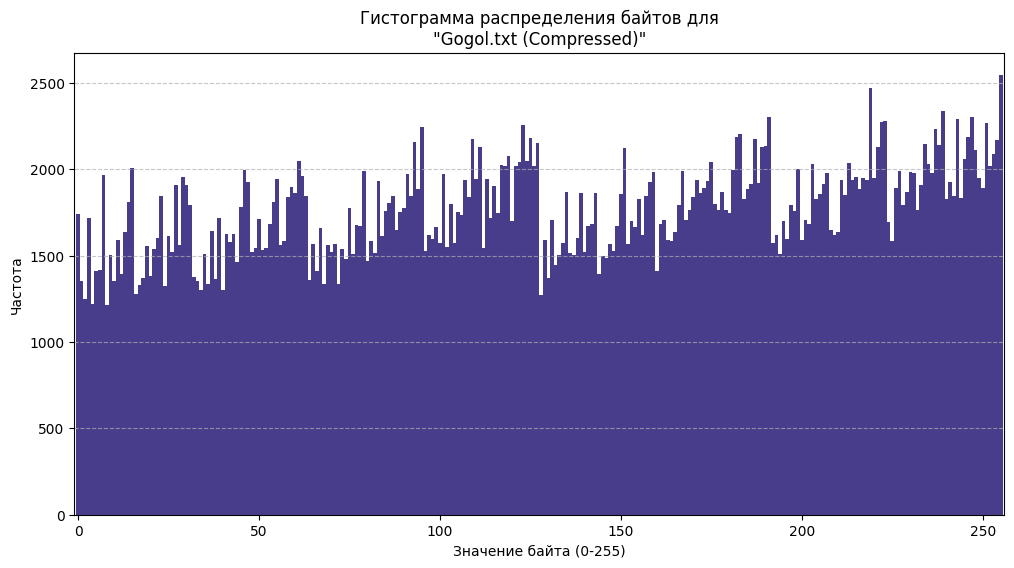

|| ЗАВЕРШЕНИЕ ОБРАБОТКИ ФАЙЛА: 'Gogol.txt'


>>> СЦЕНАРИЙ 2: Хаффман -> LZ77
    Итоговый размер: 575.05 КБ (588855 байт)
    Общий коэффициент сжатия: 76.01%


--- Энтропийный анализ для 'Gogol.txt (Compressed)' ---
Размер: 575.05 КБ (588855 байт)
Энтропия (на байт): 7.3142 бит/байт


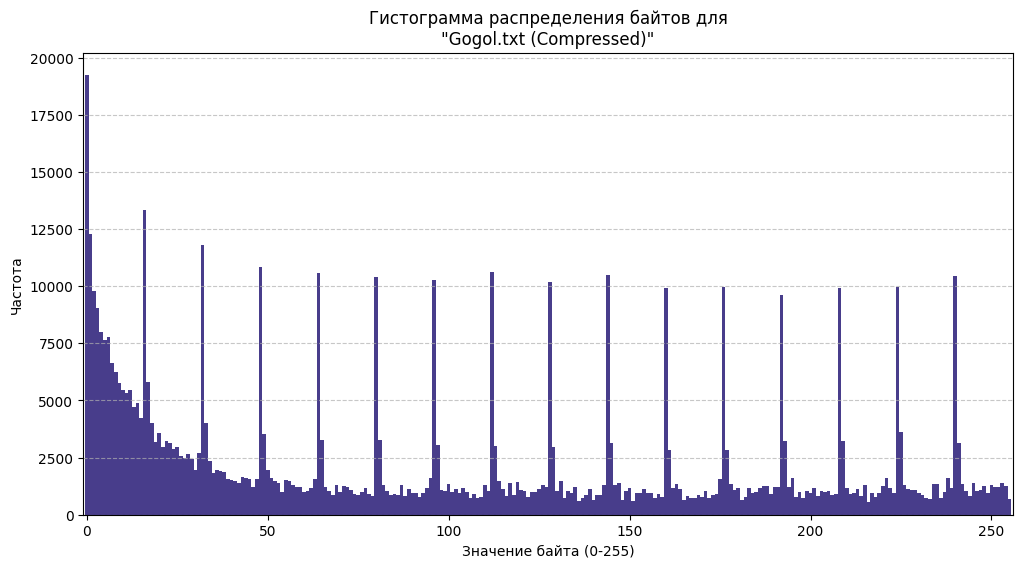

|| ЗАВЕРШЕНИЕ ОБРАБОТКИ ФАЙЛА: 'Gogol.txt'


|| АНАЛИЗ ФАЙЛА: 'RT.bmp'
Исходный размер: 1057.17 КБ (1082538 байт)

>>> Сценарий 1: LZ77 ->  Хаффман
    Итоговый размер: 937.73 КБ (960240 байт)
    Общий коэффициент сжатия: 88.70%


--- Энтропийный анализ для 'RT.bmp (Compressed)' ---
Размер: 937.73 КБ (960240 байт)
Энтропия (на байт): 7.9841 бит/байт


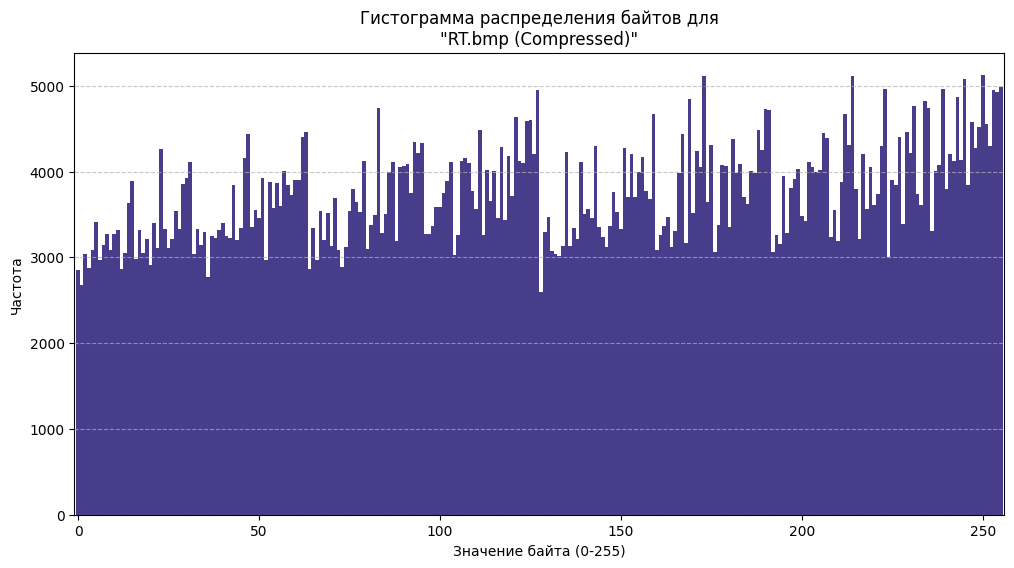

|| ЗАВЕРШЕНИЕ ОБРАБОТКИ ФАЙЛА: 'RT.bmp'


>>> СЦЕНАРИЙ 2: Хаффман -> LZ77
    Итоговый размер: 1310.74 КБ (1342197 байт)
    Общий коэффициент сжатия: 123.99%


--- Энтропийный анализ для 'RT.bmp (Compressed)' ---
Размер: 1310.74 КБ (1342197 байт)
Энтропия (на байт): 7.1608 бит/байт


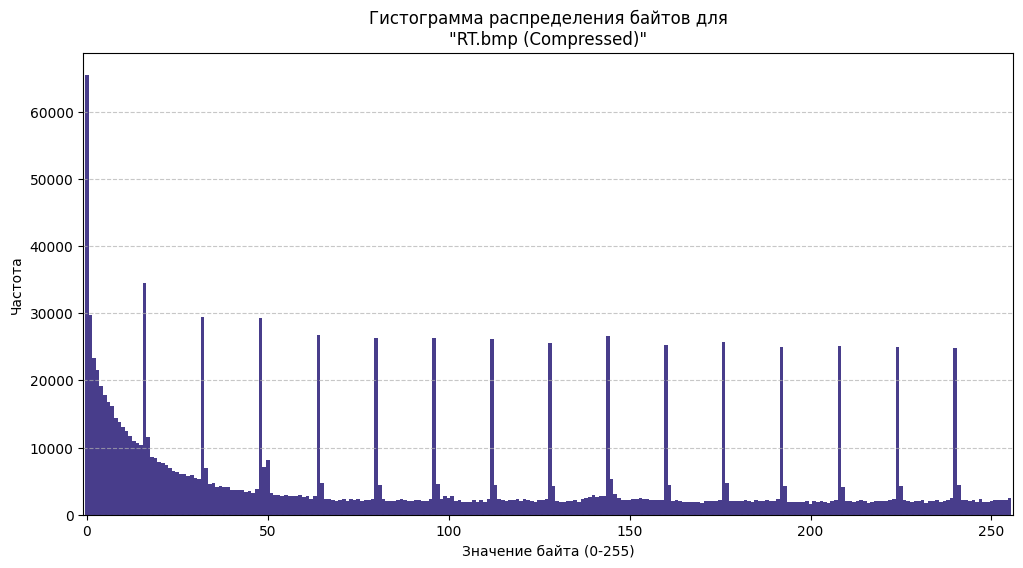

|| ЗАВЕРШЕНИЕ ОБРАБОТКИ ФАЙЛА: 'RT.bmp'




In [4]:
# --- Experiment part ---

def run_experiment_for_file(file_path):
    
    with open(file_path, 'rb') as f: original_data = f.read()
    original_size = len(original_data)
    print("=" * 70); print(f"|| АНАЛИЗ ФАЙЛА: '{file_path}'"); print("=" * 70)
    print(f"Исходный размер: {original_size / 1024:.2f} КБ ({original_size} байт)\n")

    # Scenario 1: LZ77 -> Huffman
    print(">>> Сценарий 1: LZ77 ->  Хаффман")
    lz77_output_bytes = lz77_compress_binary(original_data)
    scenario1_final_data = huffman_compress_binary(lz77_output_bytes)
    scenario1_final_size = len(scenario1_final_data)
    print(f"    Итоговый размер: {scenario1_final_size / 1024:.2f} КБ ({scenario1_final_size} байт)")
    print(f"    Общий коэффициент сжатия: {scenario1_final_size / original_size * 100:.2f}%\n")

    analyze_data_stream(scenario1_final_data, f"{file_path} (Compressed)")
    print(f"|| ЗАВЕРШЕНИЕ ОБРАБОТКИ ФАЙЛА: '{file_path}'")
    print("=" * 70 + "\n\n")

    # Scenario 2: Huffman -> LZ77
    print(">>> СЦЕНАРИЙ 2: Хаффман -> LZ77")
    huffman_output_bytes = huffman_compress_binary(original_data)
    scenario2_final_data = lz77_compress_binary(huffman_output_bytes)
    scenario2_final_size = len(scenario2_final_data)
    print(f"    Итоговый размер: {scenario2_final_size / 1024:.2f} КБ ({scenario2_final_size} байт)")
    print(f"    Общий коэффициент сжатия: {scenario2_final_size / original_size * 100:.2f}%\n")

    analyze_data_stream(scenario2_final_data, f"{file_path} (Compressed)")
    print(f"|| ЗАВЕРШЕНИЕ ОБРАБОТКИ ФАЙЛА: '{file_path}'")
    print("=" * 70 + "\n\n")

files_to_process = ['Gogol.txt', 'RT.bmp']
for file in files_to_process:
    run_experiment_for_file(file)

Как мы видим, лучше оказалась стратегия `LZ77 -> Хаффман`: в этом случае энтропия на байт почти 8 бит, а частоты байтов распределены равномерно. Именно такой метод (DEFLATE) используется в ZIP, поэтому результаты оказались довольно похожими на результаты первой лабораторной работы.

Иной подход показал себя гораздо хуже (в случае изображения мы вообще получили больший размер), причем особый интерес представляют гистограммы частоты вхождения конкретного значения байта: они приобрели спадающий вид с пиками. Можно предположить, что так вышло вследствие работы LZ77: эти пики суть часто используемые ссылки на повторяющиеся участки файла.

# Выводы
в данной лабораторной работе мы изучили алгоритмы сжатия `Хаффмана` и `LZ77`. Мы их реализовали и рассмотрели два варианта последовательного применения: `LZ77 -> Хаффман` и `Хаффман -> LZ77`. Наиболее эффективным оказался первый вариант. Это было вполне ожидаемо, так как в этом случае `LZ77` сначала заменит наиболее повторяющиеся последовательности более компактными токенами, после чего `Хаффман` будет работать уже с токенами, наиболее частым из которых он присвоит более короткий код. В ином случае `Хаффман` вначале "разрушит" всю структуру файла, и `LZ77` уже не сможет эффективно отработать, в некоторых случаях даже увеличив объем файла.